<center>

$\frac{\partial}{\partial r}\left(r \cdot \frac{\partial A}{\partial r}\right) + C_1 \cdot r = 0$

Boundary conditions:

$A(0) = 71$

$\frac{\partial A}{\partial r} |_{r=0} = 0$

Exact solution:

$71 - \frac{1}{4} C_1 \cdot r^2 = 0$

</center>


Compiling model...
'compile' took 0.000432 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [5.20e+00, 1.00e+00, 6.13e-03, 4.39e-01]    [5.25e+00, 1.00e+00, 6.13e-03, 4.39e-01]    []  


1000      [2.02e-02, 1.82e-03, 5.74e-04, 3.10e-02]    [2.03e-02, 1.82e-03, 5.74e-04, 3.10e-02]    []  
2000      [1.03e-02, 5.34e-04, 6.83e-05, 1.65e-02]    [1.04e-02, 5.34e-04, 6.83e-05, 1.65e-02]    []  
3000      [3.24e-03, 5.28e-05, 3.15e-05, 6.03e-03]    [3.25e-03, 5.28e-05, 3.15e-05, 6.03e-03]    []  
4000      [4.12e-04, 1.98e-05, 1.42e-07, 1.89e-03]    [4.14e-04, 1.98e-05, 1.42e-07, 1.89e-03]    []  
5000      [2.73e-05, 9.60e-05, 2.54e-06, 9.34e-04]    [2.76e-05, 9.60e-05, 2.54e-06, 9.34e-04]    []  
6000      [3.33e-05, 1.19e-04, 2.03e-06, 8.16e-04]    [3.32e-05, 1.19e-04, 2.03e-06, 8.16e-04]    []  
7000      [3.74e-05, 1.18e-04, 2.06e-06, 7.99e-04]    [3.71e-05, 1.18e-04, 2.06e-06, 7.99e-04]    []  
8000      [3.24e-05, 1.08e-04, 3.25e-09, 8.15e-04]    [3.21e-05, 1.08e-04, 3.25e-09, 8.15e-04]    []  
9000      [4.14e-05, 1.17e-04, 2.16e-06, 7.88e-04]    [4.09e-05, 1.17e-04, 2.16e-06, 7.88e-04]    []  
10000     [4.18e-05, 1.13e-04, 1.29e-06, 7.89e-04]    [4.14e-05, 1.13e-04

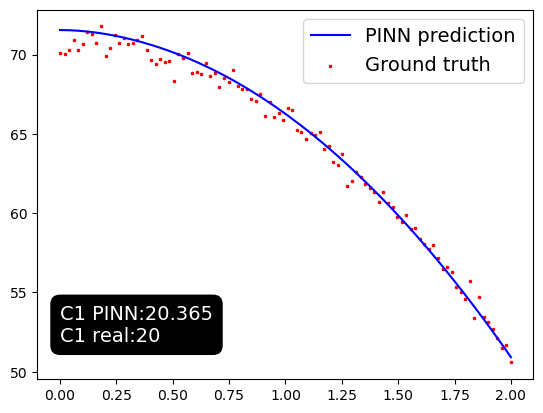

In [246]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
plt.style.use('default')
import numpy as np
torch.manual_seed(9807)
np.random.seed(9807)

C1 = dde.Variable(2.0)

domain = (0, 2)
geom = dde.geometry.Interval(domain[0], domain[-1])
# geom = dde.geometry.Interval(0, 1)

def gen_traindata(num):
    # xvals = np.linspace(0, 1, num).reshape(num, 1)
    xvals_unscaled = np.linspace(domain[0], domain[-1], num).reshape(-1, 1)
    uvals_unscaled = sol(xvals_unscaled)
    uvals_unscaled += np.random.normal(0, .5, ob_u.shape)
    # sol.scaler.fit(uvals_unscaled)
    uvals = sol.y_scaler.fit_transform(uvals_unscaled.reshape(-1, 1))
    # uvals += np.random.normal(0, 0.1, ob_u.shape)
    # xvals = sol.x_scaler.fit_transform(xvals_unscaled.reshape(-1, 1))
    xvals = xvals_unscaled

    # print(uvals)
    return xvals, uvals

def pde(x, y):
    dA_dr = dde.grad.jacobian(y, x, i=0, j=0)
    dr_dA_dr = dde.grad.jacobian(dA_dr * x, x, i=0, j=0)
    # C1 = 20
    return dr_dA_dr + C1 * x

class exact_solution():
    def __init__(self, A0=71, muJz=20):
        self.A0 = A0
        # self.A0 = 0 
        self.muJz = muJz
        self.A_max = self(0)
        self.A_min = self(1)
        self.y_scaler = MinMaxScaler()
        self.x_scaler = MinMaxScaler()
    def __call__(self, r):
        # 假设 result 的计算如下
        result = self.A0 - 1/4 * self.muJz * (r-0)**2
        return result
        # return self.A0 - 1 * self.muJz * r**2

sol = exact_solution(A0=71, muJz=20)
    
def boundary_l(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0)

def boundary_r(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1)

bc1 = dde.icbc.DirichletBC(geom, lambda x: 1, boundary_l)
bc2 = dde.icbc.NeumannBC(geom, lambda x: 0, boundary_l)
# bc2 = dde.icbc.DirichletBC(geom, sol, lambda _, on_boundary: on_boundary, component=66)

ob_x, ob_u = gen_traindata(100)
# print(ob_u)
# sdaads

observe_u = dde.icbc.PointSetBC(ob_x, ob_u)

data = dde.data.PDE(
    geom,
    pde,
    [bc1, bc2, observe_u],
    # [bc1, observe_u],
    num_domain=200,
    num_boundary=3,
    anchors=ob_x,
    num_test=1000,
)

net = dde.nn.FNN([1] + [40] * 3 + [1], "Tanh", "Glorot uniform")
# net = dde.nn.PFNN([1, [20, 20], [20, 20], [20, 20], 1], "tanh", "Glorot uniform")
model = dde.Model(data, net)
variable = dde.callbacks.VariableValue(C1, period=100, filename="variables.dat", precision=4)
model = dde.Model(data, net)
model.compile("adam", lr=0.001, external_trainable_variables=C1)
losshistory, train_state = model.train(iterations=10000, callbacks=[variable])
# model.compile("adam", lr=0.001)
# losshistory, train_state = model.train(iterations=5000)

x_unscaled = geom.uniform_points(50)
# x = sol.x_scaler.inverse_transform(x_unscaled)
x = x_unscaled
# print(x)
yhat_unscaled = model.predict(x)
yhat = sol.y_scaler.inverse_transform(yhat_unscaled)
# yhat = sol.y_scaler.transform(yhat_unscaled)
# yhat = yhat_unscaled
print(yhat_unscaled[0], yhat[0])
print("C1:", C1)
C1_unscaled =  float(C1) / float(sol.y_scaler.scale_[0])
print("C1 unscaled:", C1_unscaled)
fontsize = 14
plt.plot(x, yhat, label="PINN prediction", color="blue")
# ob_x_unscaled = sol.x_scaler.inverse_transform(ob_x)
ob_x_unscaled = ob_x
ob_u_unscaled = sol.y_scaler.inverse_transform(ob_u)
plt.scatter(ob_x_unscaled, ob_u_unscaled, label="Ground truth", c="red", marker="x", s=3)
x_position = x[0]
# y_position = sol(x[-1])
y_position = yhat[-1]
plt.text(x_position, y_position+1, "C1 PINN:{:.3f}\nC1 real:{}".format(C1_unscaled, 20),  fontsize=fontsize, color='white', bbox=dict(facecolor='black', edgecolor='none', boxstyle='round,pad=0.5'))
plt.legend(fontsize = fontsize)
# plt.text(x_position, y_position-0.2, "C1 real:{:.3f}".format(float(20)),  fontsize=fontsize, color='white', bbox=dict(facecolor='black', edgecolor='none', boxstyle='round,pad=0.5'))
# ob_u

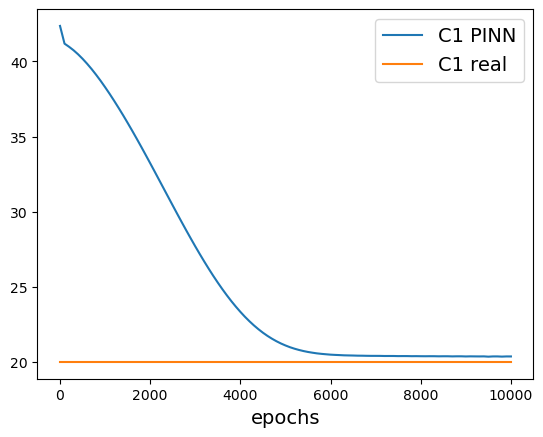

In [255]:

points = []
with open('variables.dat', 'r') as file:
    for line in file:
        index, value = line.split('[')
        index = index.strip()
        value = value.strip().strip(']').strip()
        points.append([int(index), float(value)])
points = np.array(points)
plt.plot(points[:, 0], points[:, 1]/sol.y_scaler.scale_, label="C1 PINN")
plt.plot(points[:, 0], np.ones_like(points[:, 0]) * 20, label = "C1 real")
plt.legend(fontsize = fontsize)
plt.xlabel("epochs", fontsize=fontsize)
variable.on_epoch_end()
# variable.file

In [11]:
losshistory.loss_test[0]
variable.period
with open("variables.dat", "r") as in_file:
# Read the entire contents of the file
    data = in_file.read()
    
import pandas as pd
df = pd.read_csv('variables.csv')#, header=None)#, sep='\s+|\s+')
df.head(5)
df.iloc[0]
# df_np = np.loadtxt('variables.dat')
# array = np.load('variables.npy', allow_pickle=True)


0 [2.00e+00]    500 [2.12e+00]
Name: 0, dtype: object

In [5]:
def test():
    a = 0
    b = 1
    return a, b

xxx = test()
xxx

(0, 1)

Epoch [50/500], Loss: 0.0003
Epoch [100/500], Loss: 0.0001
Epoch [150/500], Loss: 0.0000
Epoch [200/500], Loss: 0.0000
Epoch [250/500], Loss: 0.0000
Epoch [300/500], Loss: 0.0000
Epoch [350/500], Loss: 0.0000
Epoch [400/500], Loss: 0.0000
Epoch [450/500], Loss: 0.0000
Epoch [500/500], Loss: 0.0000
Test Loss: 0.0000


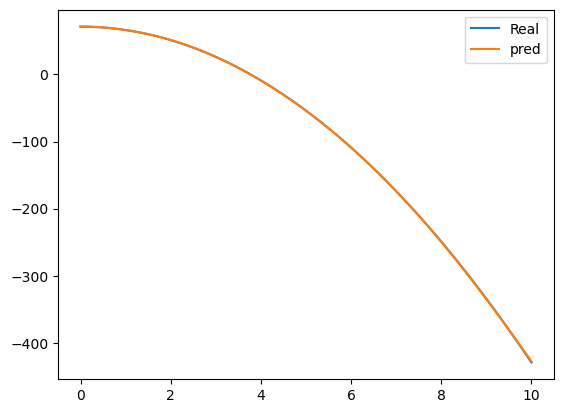

In [250]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 设置随机种子以确保可重现性
torch.manual_seed(42)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# 生成示例数据
X = torch.rand(1000, 1)  # 1000个样本，每个样本1个特征
y = 66 + (71 - 66) * X + 0.5 * torch.randn(1000, 1)  # 目标值在66到71之间，加上一些噪声
X = torch.linspace(0, 10, 1000, dtype=float).reshape(-1, 1)
y = sol(X)
X_train = X
y_train = y
# X_train = torch.tensor(scaler_X.fit_transform(X), dtype=float)
y_train = torch.tensor(scaler_y.fit_transform(y), dtype=float)
# 将数据转换为float类型
X_train, y_train = X_train.float(), y_train.float()

# 划分训练集和测试集
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = map(torch.tensor, (X_train, X_test, y_train, y_test))

# 创建数据加载器
train_dataset = TensorDataset(X_train, y_train,)
test_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 定义MLP模型
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.neurons = 40
        self.model = nn.Sequential(
            nn.Linear(1, self.neurons),  # 输入层到隐藏层
            nn.Tanh(),          # 激活函数
            # nn.ReLU(),          # 激活函数
            # nn.Linear(self.neurons, self.neurons),   # 隐藏层到输出层
            # nn.ReLU(),          # 激活函数
            nn.Linear(self.neurons, self.neurons),   # 隐藏层到输出层
            nn.Tanh(),          # 激活函数
            # nn.ReLU(),          # 激活函数
            nn.Linear(self.neurons, 1)   # 隐藏层到输出层
        )

    def forward(self, x):
        return self.model(x)


model = MLP()

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 500
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        # print(inputs)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 测试模型
model.eval()
with torch.no_grad():
    total_loss = 0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
    print(f'Test Loss: {total_loss / len(test_loader):.4f}')
    

y_pred = model(X_train)
y_pred_unscaled = scaler_y.inverse_transform(y_pred.detach().numpy())
# y_pred_unscaled = y_pred.detach().numpy()
# X_train = scaler_X.inverse_transform(X_train)
    
plt.plot(X_train, y, label = "Real")
plt.plot(X_train, y_pred_unscaled, label="pred")
plt.legend()



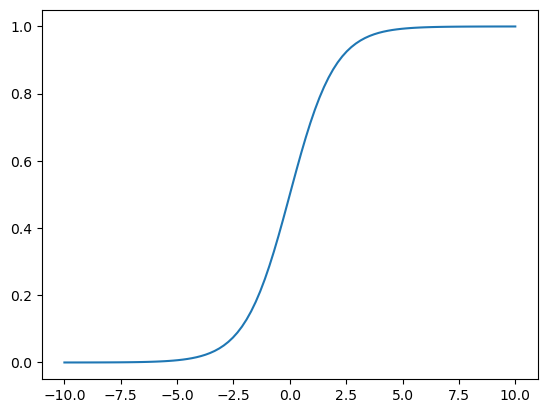

In [86]:
x_ = torch.linspace(-10, 10, 100)
y = nn.Tanh()(x_)
y = nn.Sigmoid()(x_)
plt.plot(x_, y)